## Import Dependencies

In [1]:
import PySimpleGUI as sg
import pymongo
import pandas as pd 
import csv
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import warnings
import re
import pprint
import inspect
import timeit
import pathlib
import sys

#import talos
from keras.models import Sequential
from keras.layers import Dropout, Dense
from keras.layers import LSTM


from sklearn.metrics import mean_squared_error, r2_score
#from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import sys


Using TensorFlow backend.


## Functions

In [2]:
def  traceMsg(*inpt):
    
    nl = len(inspect.stack())
    nn=0
    going=True
    stck = []
    path = ""
    while (going and nn <= nl):
       pgm = inspect.stack()[nn][3]
       if (pgm != "<module>"):
         stck.append(pgm)
         if (pgm != "traceMsg"):
            path+=f"{pgm} <= "
       else:
          going=False
          path+=f"{pgm}"
       nn+=1
#    print (f"{inpt}  from  {path} ")

def getClimateIndices(directory):
    temp = []  # temporary list/dict used throught the program 
    features = pd.DataFrame()  # this is a Pandas Dataframe that will hold the Climate Indices

    #  add year-month pairs to the features dataframe that will match the available data
    for year in range(1950,2021):
        for month in range(1,13):
            yrmo = year*100 + month
            temp.append(yrmo)

    features['yearmo'] = temp
    with os.scandir(directory) as entries:
        for entry in entries:
            if entry.is_file():
                print(entry.name)
    #  the Climate Indices are stored in flat files, so read them all in and store them in features
                file=entry.name
                file = file.rstrip("\n")
                spl = file.split(".")
                name = spl[0]
                temp = []
                tempdf = pd.DataFrame()
                with open(f"data/Climate-Indices/{file}","r") as fin:
                    line=fin.readline()
                    spl = line.split()
                    start = int(spl[0])
                    end = int(spl[1])
                    nl=0
                    process=True
                    for nn in range(start,end+1):
                       line = fin.readline()
                       spl = line.split()
                       year = int(spl[0])
                       nl+=1
                       if (nl == 1 and year > 1950):  # make sure data starts in 1950 or earlier
                          process=False
                       if (year >= 1950):
                          for val in spl[1:]:
    #                       if float(val) != -99.99:
                            temp.append(val)
                 #   print(len(temp))
    #                if len(temp) == 828:
                    if (process):
                        features[name] = temp
                        features[name] = features[name].astype('float')
        #    temp["yearmo"] = features["yearmo"][(features["yearmo"] >= start) & (features['yearmo'] <= end)].astype(float)
        features["month"] =  features["yearmo"]
    #    features["month"] = features["month"].astype(str)
        for i in range(0, len(features)): 
            yrmn = features.loc[i,"month"]
            yrmn = str(yrmn)
            features.loc[i,"month"] = yrmn[4:]
        features["month"] = features["month"].astype(int)
#        print(features.head())   
        return features
    
def selectIndices(indicesString,features,start,end,dtype):
#  dtype  0 = return observations   1 = return anomalies 
    temp = pd.DataFrame()
    indices =indicesString.split(",")
    
    for val in indices:
      val = val.lower()
#      print (val)
      temp[val] = features[val][(features["yearmo"] >= start) & (features['yearmo'] <= end)].astype(float)
      
    if (dtype == 1):
      temp["month"] = features["month"][(features["yearmo"] >= start) & (features['yearmo'] <= end)].astype(float)
#      meanIndices = pd.DataFrame({"month":[mm for mm in range(1,13)]})
      means = {}
      for col in indices:
        means[col] = {}
        for mon in range(1,13):
          df = temp[col][temp["month"] == mon]
          mean = df.mean()
          means[col][mon] = mean
    
      
      for col in indices:
        colindex = temp.columns.get_loc(col)
        temp.insert(colindex,f"{col} Anom",np.nan)
        for i,row in temp.iterrows():
            val = row[col]
            mon = row["month"]
            row[f"{col} Anom"] = val-means[col][mon]
 #     pprint.pprint(means)
      for col in indices:
          temp  = temp.drop(col,axis=1)
      temp  = temp.drop("month",axis=1)      
#      print(temp.head())
 
    nl = len(indices)
    X = temp.values.reshape(-1,nl).astype(float) 
    return (X)

def getMonth(a):
    a=str(a)
    b=a.split("-")
    return int(b[1])


def getDataCSV(city,variable):

    data_hold = {}
    years = {}
    data = pd.DataFrame()
    files = {}
    files["DENVER"] = "data/City/denver.csv"
    files["NEW ORLEANS"] = "data/City/neworleans.csv"
    files["NEW YORK"] = "data/City/newyork.csv"
    files["LOS ANGELES"] = "data/City/losangeles.csv"
    files["SAN FRANCISCO"] = "data/City/sanfrancisco.csv"
    
    data = pd.read_csv(files[city])
    # iterate over returned data from MondoDB and extract requested variable
    data["Month"] = data["Date"]
    data["Month"] = data["Month"].apply(getMonth)
    data["Date"] = data["Date"].str.replace("-","")
    data["Date"] = data["Date"].astype(int)
    
    tmax_vals=0
    tmin_vals=0
    prcp_vals=0
    tmax_miss=0
    tmin_miss=0
    prcp_miss=0
    lastrow=0
    for index,row in data.iterrows():
        if (row["TMAX"] > -98 and row["TMIN"] > -98 and row["PRCP"] > -98):
            lastrow=index
    data = data.loc[0:lastrow,:]
# check to be sure there are no missing values
    tmin_miss = data[(data["TMIN"] < -98)].count()["TMIN"]
    tmax_miss = data[(data["TMAX"] < -98)].count()["TMAX"]
    prcp_miss = data[(data["PRCP"] < -98)].count()["PRCP"]
#    print(tmin_miss,tmax_miss,prcp_miss)
    if (tmin_miss > 0):
        print(f"MISSING TMIN VALUES {tmin_miss}  ... stopping so you can deal with it")
        exit()
    if (tmax_miss > 0):
        print(f"MISSING TMAX VALUES {tmax_miss}  ... stopping so you can deal with it")
        exit()
    if (prcp_miss > 0):
        print(f"MISSING PRCP VALUES {prcp_miss}  ... stopping so you can deal with it")
        exit()
    
#     print("LI ",data.loc[lastrow,:])
                
#     print(data.head())
#     print(data.tail())
    yrmos = data["Date"].to_list()

#     reshaped data for input into neural netowrk
    y = data[variable].values.reshape(-1,1).astype(float)

    start = min(yrmos)
    end = max(yrmos)

#     yrs = [yr for yr in sorted (years.keys())]
#     #print(yrs)

    
#     hold = data[variable].values.reshape(len(yrs),12)
#     data_bymonth = pd.DataFrame(hold)
    data_checks = pd.DataFrame()
    data_checks["Obs"] = data[variable]
    data_checks["Date"] = yrmos
    data_checks.insert(0,"Var",variable)

    #     print(data_checks.head())
# #    data_bymonth.rename(columns={0:"Jan",1:"Feb",2:"Mar",3:"Apr",4:"May",5:"Jun",6:"Jul",7:"Aug",8:"Sep",9:"Oct",10:"Nov",11:"Dec"},inplace=True)
#     data_bymonth["Year"] = yrs
# #    print(data_bymonth.head())
#     Stats = {}
#     Means = []
#     Stds = []
#     Mons = []
#     for mon in data_bymonth.columns:
#         Stats[mon]={}
#         data_bymonth[mon]=data_bymonth[mon].astype(float)
#         Stats[mon]['std'] = data_bymonth[mon].std()
#         Stats[mon]['mean'] = data_bymonth[mon].mean()
#         Stds.append(Stats[mon]['std'])
#         Means.append(Stats[mon]['mean'])
#         Mons.append(mon)
    
#     data_bymonth  = data_bymonth.set_index("Year")
#     if (dtype == 0):   #  Return actual Monthly means for the variable
#         return y,yrs,yrmos,Stats,Means,Stds,data_checks
#     y=[]
#     zz = []
#     for index,row in data_bymonth.iterrows():
#         for mon in range(0,12):
#             anom = data_bymonth.loc[index,mon] - Means[mon]
#             yy=[]
#             yy.append(anom)
#             zz.append(anom)
#             y.append(yy)
#   #  data_bymonth['Year'] = yrs
#     #print(data_bymonth.head())
#     data_checks["Anom"] = zz
#     traceMsg("done")
#    return y,yrs,yrmos,Stats,Means,Stds,data_checks
    return y,yrmos,data_checks,start,end
 
    
def leastDen(a,b):
   
    c = a%b
    d = b-c
   
#    e=d%a
    return d,c

def trainFB(XXX,yyy,nsplit,toScale,phase,yrmos,fb,nbatch,nperiod):
    ''' create a Train, Test and Experiment datasets out of the input data. If toScale=1, then
    the data will also be scaled.  If toScale=0, the data will not be scaled.  The Experiment 
    time series will be the last nsplit values in the XX and yy lists. The Experiment time series 
    will be used for creating prediction scores'''
    
    info = {}
    info["y_test"] = {}
    info["y_train"] = {}
    ninst = len(yyy)  # length of input time series
##  adjust orignal TS for phase shift
    yy = yyy[phase:]
    yrmosShift = yrmos[phase:]
    XX = XXX[0:ninst-phase]
    ntlen=ninst
    ninst = len(yy)  # length of input time series
#    print ("LENS ",len(yy),len(XX))
    
## split off end of TS for experimental testing, if nsplit > 0
    y=yy[0:ninst-nsplit]  #  this will be used to create the Train and Test time sries for the dependant variables
    X=XX[0:ninst-nsplit]  #  this will be used to create the Train and Test time series for the independant variables
    if (nsplit > 0):
        X_exp = XX[ninst-nsplit:]  # create the X experimental dataset for predictions
        y_exp = yy[ninst-nsplit:]  # create the y experimental dataset for predictions
    else:
        X_exp = []
        y_exp = []
    yrmosShift = yrmosShift[0:ninst-nsplit]
    feature_info = ""
   
## compute lenth of training time series 
    nlen = int(len(y)*.8)  # use 80% of data for training
#     print("NLEN ",nlen)
#  New method for train and test datea keeps time series togther instead of using random selected points
    if (fb == 1): # Train data from front of TS, testing at back
        X_train = X[:nlen] 
        X_test = X[nlen:] 
        y_train = y[:nlen] 
        y_test = y[nlen:] 
        
        info["y_train"]["start"] = phase
        info["y_train"]["end"] = phase+nlen-1
        info["y_test"]["start"] = phase+nlen
        info["y_test"]["end"] = phase+ninst-nsplit-1
        yrmosTrain = yrmosShift[:nlen]
        yrmosTest = yrmosShift[nlen:]    
    elif (fb == 2): # Train data from end of TS, testing data from front
        nl = len(y) - nlen
        
        X_train = X[nl:] 
        X_test = X[:nl] 
        y_train = y[nl:] 
        y_test = y[:nl] 
        info["y_train"]["start"] = phase+nl
        info["y_train"]["end"] =  phase+len(y)-1
        info["y_test"]["start"] = phase
        info["y_test"]["end"] = phase+nl-1
        yrmosTrain = yrmosShift[nl:]
        yrmosTest = yrmosShift[:nl]

##  adjust time series for window length 
## handled by reshape now
#     yrmosTrain = yrmosTrain[nperiod:]
#     yrmosTest = yrmosTest[nperiod:]
#     y_train = y_train[nperiod:]
#     y_test = y_test[nperiod:]

#     X_train = X_train[nperiod:]
#     X_test = X_test[nperiod:]
#     info["y_train"]["start"]+=nperiod
#     info["y_test"]["start"]+=nperiod

#     print ("OK  ",len(y_train),len(yrmosTrain))
#     print ("OK  ",len(y_test),len(yrmosTest))
    
## if using a batch_size, then make sure length of ts is divisible by batch_size    
##  this needs to be the last step done, so it is done in reshape
#     if (nbatch > 0):
#         newl,dif = leastDen(len(X_train),nbatch)
#         ol = len(X_train)
#         print ("OLEN ",len(X_train),len(y_train),len(yrmosTrain))
#         X_train = X_train[dif:]
#         y_train = y_train[dif:]
#         info["y_train"]["start"] =  info["y_train"]["start"] + dif
#         yrmosTrain=yrmosTrain[dif:]
#         print("LLEN ",ol,nbatch,len(X_train),len(y_train),len(yrmosTrain))
        
#     print ("X LEN ",len(X_train))
#     print ("y LEN ",len(y_train))
#     print ("yr LEN ",len(yrmosTrain))
    X_scaler = StandardScaler().fit(X_train)
    y_scaler = StandardScaler().fit(y_train)
    if (nsplit > 0):
        X_exp_scaled = X_scaler.transform(X_exp)
    else:
        X_exp_scaled = []
        
    if (toScale == 0):  # do not scale data, so return the unsclaled Train,Test and Experiment data
#        return (X_train,X_test,X_exp,y_train,y_test,y_exp,feature_info,X_scaler,y_scaler)
        X_train_scaled = np.array(X_train)
        X_test_scaled = np.array(X_test)
        y_train_scaled = np.array(y_train)
        y_test_scaled = np.array(y_test)
        return (info,yrmosTrain,yrmosTest,X_train_scaled,X_test_scaled,
        X_exp_scaled,y_train_scaled,y_test_scaled,y_exp,feature_info,
        X_scaler,y_scaler,y_train,y_test,nlen,ntlen)

    
#  create the scaled Train,Test and Predictio time series for the dependent variable    
    X_train_scaled = X_scaler.transform(X_train)
    X_test_scaled = X_scaler.transform(X_test)
 

#  create the scaled Train,Test and Predictio time series for the independent variable  
    y_train_scaled = y_scaler.transform(y_train)
    y_test_scaled = y_scaler.transform(y_test)
 #   y_exp_scaled = y_scaler.transform(y_exp)

    return (info,yrmosTrain,yrmosTest,X_train_scaled,X_test_scaled,X_exp_scaled,y_train_scaled, \
            y_test_scaled,y_exp,feature_info,X_scaler,y_scaler,y_train,y_test,nlen,ntlen)

def reshapeTS(Xts,yts,nbatch,nperiod,how,yrmos,ino,ttp):
    
##  ttp = time series that is being reshaped... 1 = train, 2 = test
##  how = how to re-arrange the time series... either as
##        1 = [timesteps,features]
##        2 = [features,timesteps]
# yrmosTrain = yrmosTrain[nperiod:]
#     yrmosTest = yrmosTest[nperiod:]
#     y_train = y_train[nperiod:]
#     y_test = y_test[nperiod:]
#     X_train = X_train[nperiod:]
#     X_test = X_test[nperiod:]
#     info["y_train"]["start"]+=nperiod
#     info["y_test"]["start"]+=nperiod    
    traceMsg("INO ",ino)
    Xtsnew = []
    nlen = len(Xts)
    nfeats = Xts.shape[1]
#    traceMsg("start reshape ",nlen,nfeats,ts.shape,ts[0:10])
    nit=0
    if (how == 1):
        for ii in range(nperiod,nlen):
            tmp = []
            for jj in range(nit,ii+1):
                tmp.append(Xts[jj])
            Xtsnew.append(tmp)
            nit+=1
    elif (how == 2):
        for ii in range(nperiod,nlen):
            tmp = []
            for jj in range(0,nfeats):
                hld = []
                for mm in range(ii-nperiod,ii+1):
                    hld.append(Xts[mm][jj])
                tmp.append(hld)
                
            Xtsnew.append(tmp)    
  
    Xtsnew = np.array(Xtsnew)
    
    yts = yts[nperiod:]
    yrmos = yrmos[nperiod:]
    if (ttp == 1):
        ino["y_train"]["start"]+=nperiod
    elif (ttp ==2):
        ino["y_test"]["start"]+=nperiod
#    tsnew = tsnew.reshape(len(tsnew),nperiod+1,nfeats)
#    print("shape ",nperiod,tsnew[0:3])
#    npr = nperiod

## if using a batch_size, then make sure length of ts is divisible by batch_size    
##  
    if (nbatch > 0):
        newl,dif = leastDen(len(Xtsnew),nbatch)
        ol = len(Xtsnew)
#        print ("OLEN ",len(Xtsnew),len(yts),len(yrmos))
        Xtsnew = Xtsnew[dif:]
        yts = yts[dif:]
        yrmos=yrmos[dif:]
        if (ttp ==1):
             ino["y_train"]["start"]+= dif
        elif (ttp == 2):
             ino["y_test"]["start"]+= dif
        print("LLEN ",ol,nbatch,len(Xtsnew),len(yts),len(yrmos))


    return Xtsnew,yts,yrmos,ino

def Stats(ttp,R2,y_ts,y_ts_predict,yrmosNew,city,variable,dtype,neuro,nbatches,nphase,
          nperiod,nlen,info,data_checks):
    print ("STAT NPER ",nperiod)
    if (ttp == 1):
##        y_ts = [mm[0] for mm in y_train]
#        y_ts_predict = [mm[0] for mm in y_train_predict]
#        yrmosNew = yrmosTrain[nperiod:]
#        diffs=data_checks.loc[nphase+nperiod:nlen+nphase-1]
        ntststrt = info["y_train"]["start"]
        ntstend = info["y_train"]["end"]
        diffs=data_checks.loc[ntststrt:ntstend]
    elif (ttp == 2):
#        y_ts = [mm[0] for mm in y_test]
#        y_ts_predict = [mm[0] for mm in y_test_predict] 
#        yrmosNew = yrmosTest[nperiod:]
        ntststrt = info["y_test"]["start"]
        ntstend = info["y_test"]["end"]
        diffs=data_checks.loc[ntststrt:ntstend]
#    print("LD ",ttp,len(diffs))
    diffs = diffs.set_index("Date")
  
    diffs["Months"] = [ int(str(m)[4:6]) for m in yrmosNew]
#    print ("DF ",len(y_ts),len(y_ts_predict),len(diffs))
    diffs["Train Obs"] = y_ts
    diffs["Train Pred"] = y_ts_predict
  
    diffs["Obs-Pred"] = diffs["Train Obs"] - diffs["Train Pred"]
    diffs["abs(Obs-Pred)"] = abs(diffs["Train Obs"] - diffs["Train Pred"])
    hld = []
    hldp = []

    df = pd.DataFrame()
    
    df["Mean Obs"] = diffs.groupby(["Months"]).mean()["Train Obs"]
    df["Mean Pred"] = diffs.groupby(["Months"]).mean()["Train Pred"]
    df["Mean O-P"] = diffs.groupby(["Months"]).mean()["Obs-Pred"]
    df["Mean abs(O-P)"] = diffs.groupby(["Months"]).mean()["abs(Obs-Pred)"]

    df["StdD Obs"] = diffs.groupby(["Months"]).std()["Train Obs"]
    df["StdD Pred"] = diffs.groupby(["Months"]).std()["Train Pred"]
    df["StdD O-P"] = diffs.groupby(["Months"]).std()["Obs-Pred"]
    df["StdD abs(O-P)"] = diffs.groupby(["Months"]).std()["abs(Obs-Pred)"]
    df["abs(O-P)/Std"] = df["Mean abs(O-P)"]/df["StdD Obs"]
    df.insert(0,"City",city)
    df.insert(1,"Var",variable)
    df.insert(2,"Phase",nphase)
    df.insert(3,"Period",nperiod)
#    df.insert(4,"Batches",nbatches)
    df.insert(4,"Dtype",dtype)
    df.insert(5,"Ttype",ttp)
    df.insert(6,"Start",yrmosNew[0])
    df.insert(7,"End",yrmosNew[-1])
    if (interactive == 1):
       window2["out"].print(ttp,"df ",df.head())
    df["Month"] = [m for m in range(1,13)]
#    print (diffs.head())
    wi = df[(df["Month"] == 1) |  (df["Month"] == 12) | (df["Month"] == 2)]
    sp = df[(df["Month"] == 3) |  (df["Month"] == 4) | (df["Month"] == 5)]
    su = df[(df["Month"] == 6) |  (df["Month"] == 7) | (df["Month"] == 8)]  
    fa = df[(df["Month"] == 9) |  (df["Month"] == 10) | (df["Month"] == 11)]
    summary_df = pd.DataFrame()
    summary_df["City"] = [city]
    summary_df["Var"] = [variable]
    summary_df["Period"] = nperiod
    summary_df["Phase"] = nphase
    if (neuro == 1):
        neuro = "NoB"
        nbatches = "-"
    elif (neuro == 2):
        neuro = "Btch"
    summary_df["Neuro_How"] = neuro
    summary_df["Batches"] = nbatches
    summary_df["D-Type"] = dtype
    summary_df["T-Type"] = ttp
    summary_df["Start"] = [yrmosNew[0]]
    summary_df["End"] = [yrmosNew[-1]]
    summary_df["Winter"] = [wi["abs(O-P)/Std"].mean()]
    summary_df["Spring"] = [sp["abs(O-P)/Std"].mean()]
    summary_df["Summer"] = [su["abs(O-P)/Std"].mean()]
    summary_df["Fall"] = [fa["abs(O-P)/Std"].mean()]
    summary_df["R2"] = R2
#    print (ttp,summary_df)
    return df,summary_df



# def neuralLSTMTT(neuro_how,y_train,y_test,X_train_scaled,y_train_scaled,X_test_scaled,
#                  y_test_scaled,first_neuron,layer,dtype,fb):

def neuralLSTMTT(city,variable,indices,neuro_how,first_neuron,layer,dtype,fb,nperiod,
                 nbatches,nsplit,nphase,interactive):
#  dtype   -  1 = use actual obs   2 = use anaomalies
#  nphase  - amount of the phase shift
#  nperiod - how many time steps to go back in time for each point
#  ttype   - 1 = use Training data for stats   2 = use Test data for stats
#    nbatches = 8
    nepochs = 10
    nneurons= 10
    print ("PPERIOD ",nperiod)
 #   traceMsg("INFO  ",info)
    path = os.path.abspath('')
    features = getClimateIndices(f"{path}/data/Climate-Indices/")        
    #(y,yrs,yrmos,cityStats,cityMeans,cityStds,data_checks) = getData(city,variable,dtype)
    (y,yrmos,data_checks,start,end) = getDataCSV(city,variable)
    X = selectIndices(indices,features,start,end,dtype)

#    print(city,variable)
#    print("lens ",len(y),len(X))
 
    yy = [nn for nn in y]
    (info,yrmosTrain,yrmosTest,X_train_scaled,X_test_scaled,X_exp_scaled,y_train_scaled, \
    y_test_scaled,y_exp_scaled,feature_info,X_scaler,y_scaler,
    y_train,y_test,nlen,ntlen) = \
    trainFB(X,yy,nsplit,1,nphase,yrmos,fb,nbatches,nperiod)

#     y_train = y_train[nperiod:]
#     y_test = y_test[nperiod:]
#     info["y_train"]["start"]+=nperiod
#     info["y_test"]["start"]+=nperiod


#    traceMsg("AF ",len(X_train_scaled),len(y_train_scaled))
#    print("lens yrmo ",len(yrmosTrain),len(yrmosTest))
    

    y_train_scaled = y_train_scaled.reshape((y_train_scaled.shape[0]))
    y_test_scaled = y_test_scaled.reshape((y_test_scaled.shape[0]))

#    y_train_scaled = y_train_scaled[nperiod:]
#    y_test_scaled = y_test_scaled[nperiod:]

#    reshapeTS(Xts,yts,nperiod,how,yrmos,info):
    X_train_scaled,y_train_scaled,yrmosTrain,info = \
    reshapeTS(X_train_scaled,y_train_scaled,nbatches,nperiod,2, \
    yrmosTrain,info,1)
    X_test_scaled,y_test_scaled,yrmosTest,info  = \
    reshapeTS(X_test_scaled,y_test_scaled,nbatches,nperiod,2,yrmosTest, \
    info,2)
#    print ("FL ",len(X_train_scaled),len(y_train_scaled))
    
 #   print ("TRAIN ",X_train_scaled)
    if (nsplit > 0):
        X_exp_scaled = reshapeTS(X_exp_scaled,nperiod)
    #y_train_scaled = y_train_scaled.reshape((y_train_scaled.shape[0], nperiod+1, y_train_scaled.shape[1]))
    #X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], nperiod+1, X_train_scaled.shape[1]))
   

#    traceMsg("SHAPE ",X_train_scaled.shape)
    model = Sequential()
#    print ("X_train",X_train_scaled[0:10])
#    print("y_train_scaled",y_train_scaled[0:10])
    if (neuro_how == 1):
#         model.add(LSTM(50,  return_sequences=True,input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])))
#         model.add(LSTM(first_neuron, return_sequences=True))
#         model.add(LSTM(first_neuron))
#         model.add(Dense(1))    
#         model.compile(loss='mae', optimizer='adam')
#         history = model.fit(X_train_scaled, y_train_scaled, epochs=50, 
#         validation_data=(X_test_scaled, y_test_scaled),batch_size=24, verbose=0, shuffle=False)
#         y_train_predict = model.predict(X_train_scaled)
#         y_test_predict = model.predict(X_test_scaled)
#         y_train_predict = [mm[0] for mm in y_train_predict]
#         y_train = [mm[0] for mm in y_train]   
#         y_test_predict = [mm[0] for mm in y_test_predict]  
#         print("YtrainP ",y_train_predict)
#         r2_test=0
#         r2_train=0

#         X_train_scaled = X_train_scaled[1:]
#         y_train_scaled = y_train_scaled[1:]
#         y_train = y_train[1:]
        
        model = Sequential()
    #    model.add(LSTM(50, input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])))
        model.add(LSTM(64, return_sequences=True,input_shape=(X_train_scaled.shape[1], 
        X_train_scaled.shape[2])))
        model.add(LSTM(64, return_sequences=True))
        model.add(LSTM(64))
        model.add(Dense(1))
        model.add(Dense(1))
        model.add(Dense(1))
        model.add(Dense(1))
        model.add(Dense(1))
        model.compile(loss='mae', optimizer='adam')
        r_train=0
        r_test=0
        
        history = model.fit(X_train_scaled, y_train_scaled, epochs=50, batch_size=24, validation_data=(X_test_scaled, y_test_scaled), verbose=0, shuffle=False)
        # plot history
        plt.plot(history.history['loss'], label='train')
        plt.plot(history.history['val_loss'], label='test')
        plt.legend()
        plt.show()
        if (nsplit > 0):
            y_predict = model.predict(X_exp_scaled)
            y_predict = y_scaler.inverse_transform(y_predict)
        y_train_predict = model.predict(X_train_scaled)
        y_train_predict = y_scaler.inverse_transform(y_train_predict)
   
        y_test_predict = model.predict(X_test_scaled)
        y_test_predict = y_scaler.inverse_transform(y_test_predict)
        y_train_scaled = y_scaler.inverse_transform(y_train_scaled)
        y_test_scaled = y_scaler.inverse_transform(y_test_scaled)
        y_train_predict = [mm[0] for mm in y_train_predict]
        y_test_predict = [mm[0] for mm in y_test_predict]
        y_train = [mm[0] for mm in y_train]
        y_test = [mm[0] for mm in y_test]
        
        r2_train=0
        r2_test=0
        
        
        
        
        ###
#    print("XX ",X_train_scaled)
    elif (neuro_how == 2):  # use a non-1 batch size
 
#        print("YY ",y_train_scaled)
#        print("X sdhape ",X_train_scaled.shape)
        model.add(LSTM(nneurons, stateful=True,batch_size=nbatches,
        batch_input_shape=(nbatches,X_train_scaled.shape[1], X_train_scaled.shape[2])))
        model.add(Dense(1))
        model.compile(loss='mae', optimizer='adam')
#        print("XY LEN ",len(X_train_scaled),len(y_train_scaled))
        for i in range(nepochs):
             model.fit(X_train_scaled, y_train_scaled, epochs=1,
             batch_size=nbatches,verbose=1, shuffle=False)
             model.reset_states()

        y_train_predict = model.predict(X_train_scaled,batch_size=nbatches)
    #    r2_train = r2_score(y_train_scaled,y_train_predict)
        r2_train=0
        y_train_predict = y_scaler.inverse_transform(y_train_predict)
        y_train_scaled = y_scaler.inverse_transform(y_train_scaled)
        y_test_scaled = y_scaler.inverse_transform(y_test_scaled)
        y_train_predict = [mm[0] for mm in y_train_predict]
        y_train = [mm[0] for mm in y_train]    
        
#    print("YTrP ",y_train_predict.shape)
#    print(y_train_predict)
        nbatches=1
        new_model = Sequential()
        new_model.add(LSTM(nneurons, batch_input_shape=(nbatches, 
        X_train_scaled.shape[1], X_train_scaled.shape[2]), stateful=True))
        new_model.add(Dense(1))
        # copy weights
        old_weights = model.get_weights()
        new_model.set_weights(old_weights)
        # compile model
        new_model.compile(loss='mean_squared_error', optimizer='adam')        

        y_test_predict = []
        for i in range(len(X_test_scaled)):
            testy =  y_test_scaled[i]
            testX = X_test_scaled[i]

     #     testX = testX.reshape(1, 6, 4)
            testX = testX.reshape(1, X_test_scaled.shape[1], X_test_scaled.shape[2])
      #      print("etstx B",testX.shape)
            yhat = new_model.predict(testX, batch_size=1)
            y_test_predict.append(yhat)
      #      print('>Expected=%.1f, Predicted=%.1f' % (testy, yhat))    
        
        y_test_predict = y_scaler.inverse_transform(y_test_predict)
        y_test_predict = [mm[0][0] for mm in y_test_predict]
        r2_test=0
        y_test = [mm[0] for mm in y_test]

#     if (nsplit > 0):
#         y_predict = model.predict(X_exp_scaled)
#         y_predict = y_scaler.inverse_transform(y_predict)
    if (interactive == 1):
        window2["out"].print("train ",y_train[0:10])
        window2["out"].print("test ",y_test[0:10])

        window2["out"].print("train_p ",y_train_predict[0:10])
        window2["out"].print("test_p ",y_test_predict[0:10])
  
#    r2_test = r2_score(y_test_scaled,y_test_predict)
   
#    print("R2 ",r2_train,r2_test)

#    print("y_tp",y_test_predict)
    df_test,summry_test = Stats(2,r2_test,y_test_scaled,y_test_predict,yrmosTest,city,variable,dtype,neuro_how,nbatches,nphase,nperiod,nlen,info,data_checks) 
    df_train,summry_train = Stats(1,r2_train,y_train_scaled,y_train_predict,yrmosTrain,city,variable,dtype,neuro_how,nbatches,nphase,nperiod,nlen,info,data_checks)


    return summry_train,summry_test
 

## GUI

In [3]:
# Create some elements
def runApp(nbatches,neuro_how,nphase,nperiod,nit,summry,interactive):
#    neuro_how = 2  #  1 use old way, no batch size set, 2 = set batch size
#    nit = 0
    indices = "nina1,nina4,oni,tni"                              
    city = "DENVER"
    variable = "TMIN"
    dtype = 0  #  0 = Actual monthly observations    1 = Monthly anomalies
    ttype = 2  #  1 = use Training data for stats    2 = using Testing data for stats
#    nphase=2
    nlayers=0
    nnodes=0
    #nsplit=24
    nsplit=0
#    nperiod = 5
#    nbatches = 4
    first_neuron = 50
    layer = 1
    fb=1
    ###-----------------
    sum_trn,sum_tst = neuralLSTMTT(city,variable,indices,neuro_how,first_neuron,layer,
                                   dtype,fb,nperiod,nbatches,nsplit,nphase,interactive)

    sum_trn = sum_trn.rename(columns = {"R2":"Tr R2","Winter":"Tr Wi","Spring":"Tr Sp","Summer":"Tr Su","Fall":"Tr Fa"})
    #       sum_tst = sum_tst.rename({"Winter":"Test Winter","Spring":"Test Spring","Summer":"Test Summer","Fall":"Test Fall"})
    nit+=1
    summryh = sum_trn
    summryh["Te Wi"] = sum_tst["Winter"]
    summryh["Te Sp"] = sum_tst["Spring"]
    summryh["Te Su"] = sum_tst["Summer"]
    summryh["Te Fa"] = sum_tst["Fall"]
    summryh["Te R2"] = sum_tst["R2"]
    #         summry["Phase"] = nphase
    summryh["Lyr"] = layer
    summryh["Fi Nu"] = first_neuron
    summryh["FB"] = fb
    print ("NIT ",nit)
    if (nit > 1):
        summry = summry.append(summryh)
    else:
        summry = summryh
    temp = ["Tr Wi","Tr Sp","Tr Su","Tr Fa","Te Wi","Te Sp","Te Su","Te Fa"]
    print (summry.head())
    for key in temp:
        summry[key]=summry[key].astype(float)
        summry[key] = summry[key].map("{:,.2f}".format)
    new_summry = summry[["City","Var","Phase","Period","Neuro_How","Batches","Tr Wi","Te Wi","Tr Sp",
                         "Te Sp","Tr Su","Te Su","Tr Fa","Te Fa"]]
    new_summry.rename(columns={"Neuro_How":"Neu","Phase":"Phs","Period":"Wndw"})
    new_summry_list = new_summry.values.tolist()
#    print(new_summry_list)
    return new_summry,new_summry_list,nit
#    window["output"].update(new_summry)

###########  -----------------------------  #######################    
header_list = ["City","Var","Phs","Wndw","Neur","Btch","Tr Wi","Te Wi","Tr Sp","Te Sp","Tr Su","Te Su","Tr Fa","Te Fa"]
 
layout = [[sg.Multiline(size=(60,30),autoscroll=True,auto_size_text=True, key="out")]]
# Create the Window
window2 = sg.Window('Output', layout,finalize=True,resizable=True)
    
layout = [[sg.Text("What's your name?"), sg.InputText()],
          [sg.Listbox([0,1,2,3,4,5,6,7,8,9,10,11,12], size=(10, 1),key="LB")],
          [sg.Text('Phase Shift'), sg.Slider((0, 200), orientation='h',
                                 enable_events=True, key='phs')],
          [sg.Text('Window Size'), sg.Slider((0,60), orientation='h',
                                 enable_events=True, key='wndw')],
          [sg.Radio('No Batch', 1, enable_events=True, default=True,key='NoB'),
                                 sg.Radio('Batch',1, enable_events=True, key='BtCH')],
          [sg.Text('Batch Size'), sg.Slider((0,40), orientation='h',
                                 enable_events=True, key='btch')],
          [sg.Button('Run'), sg.Button('Quit')],
          [sg.Text(f'Output value:', size=(20,1))],
 #         [sg.Multiline(size=(90,30), key="output")]
          [sg.Table(values=[['' for _ in range(len(header_list))]], max_col_width=10,
               background_color='lightblue',
               auto_size_columns=True,
               justification='center',alternating_row_color='blue',
               key='_table_', headings = header_list)]
         ]
# Create the Window
window = sg.Window('Hello PySimpleGUI', layout,finalize=True,location=[100,100])
#Create the event loop
nit=0
summry = pd.DataFrame()

# window1, window2 = make_win1(), make_win2()

window2.move(window.current_location()[0]+600, window.current_location()[1])
interactive=1 #  1 = use GUI, 2 = run w/o gui

while True:
  
    event, values = window.read()

#    window, event, values = sg.read_all_windows()
    if event == sg.WIN_CLOSED or event == 'Quit':
#        window.close()
#        sys.exit(1)
        what = "QUIT"
        break
    elif event in ('Run'):
        print("VV ",values)
        phase = int(values["phs"])
        period = int(values["wndw"])
        print ("Input ",phase,period)
        if (values["NoB"] == True):
            neuro_h = 1
        else:
            neuro_h = 2
        nbatch = int(values["btch"])
        what = "RUN"
        summry, new_list,nit = runApp(nbatch,neuro_h,phase,period,nit,summry,interactive)
        window.FindElement("_table_").Update(new_list)


window.close()

*** tk version 8.6.9 detected.... patching ttk treeview code ***


PPERIOD  10
ammsst.data.txt
amon.us.data.txt
epo.data.txt
nao.data.txt
nina1.data.txt
nina3.data.txt
nina4.data.txt
NTA_ersst.data.txt
oni.data.txt
pna.data.txt
qbo.data.txt
tna.data.txt
tni.data.txt
tsa.data.txt
whwp.data.txt
wp.data.txt
LLEN  670 2 670 670 670
LLEN  160 2 160 160 160


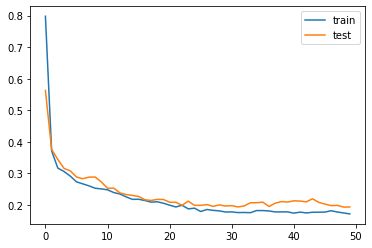

STAT NPER  10
STAT NPER  10
NIT  5
  Batches    City  D-Type       End   FB  Fi Nu  Lyr Neuro_How  Period  Phase  \
0       -  DENVER     NaN       NaN  NaN    NaN  NaN       NoB      10      1   
0       -  DENVER     NaN       NaN  NaN    NaN  NaN       NoB      10      1   
0       -  DENVER     NaN       NaN  NaN    NaN  NaN       NoB      10      1   
0       -  DENVER     NaN       NaN  NaN    NaN  NaN       NoB      10      1   
0       -  DENVER     0.0  200608.0  1.0   50.0  1.0       NoB      10      0   

   ...  Te R2    Te Sp    Te Su     Te Wi    Tr Fa Tr R2     Tr Sp    Tr Su  \
0  ...    NaN     1.20     1.22      0.97     0.96   NaN      0.96     0.92   
0  ...    NaN     1.09     1.28      0.88     0.88   NaN      0.92     0.87   
0  ...    NaN     1.11     1.20      0.97     0.89   NaN      0.83     0.84   
0  ...    NaN     1.32     1.28      0.91     0.98   NaN      0.80     0.81   
0  ...    0.0  1.26955  1.19896  0.820317  0.99743   0.0  0.855397  1.00675   

   

C:\Users\Science Joe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


LLEN  669 2 668 668 668
LLEN  160 2 160 160 160


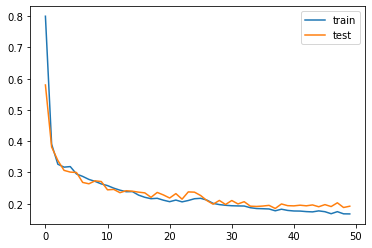

STAT NPER  10
STAT NPER  10
NIT  6
  Batches    City  D-Type  End  FB  Fi Nu  Lyr Neuro_How  Period  Phase  ...  \
0       -  DENVER     NaN  NaN NaN    NaN  NaN       NoB      10      1  ...   
0       -  DENVER     NaN  NaN NaN    NaN  NaN       NoB      10      1  ...   
0       -  DENVER     NaN  NaN NaN    NaN  NaN       NoB      10      1  ...   
0       -  DENVER     NaN  NaN NaN    NaN  NaN       NoB      10      1  ...   
0       -  DENVER     NaN  NaN NaN    NaN  NaN       NoB      10      0  ...   

   Te R2  Te Sp Te Su  Te Wi Tr Fa Tr R2 Tr Sp Tr Su  Tr Wi   Var  
0    NaN   1.20  1.22   0.97  0.96   NaN  0.96  0.92   0.77  TMIN  
0    NaN   1.09  1.28   0.88  0.88   NaN  0.92  0.87   0.77  TMIN  
0    NaN   1.11  1.20   0.97  0.89   NaN  0.83  0.84   0.77  TMIN  
0    NaN   1.32  1.28   0.91  0.98   NaN  0.80  0.81   0.81  TMIN  
0    NaN   1.27  1.20   0.82  1.00   NaN  0.86  1.01   0.77  TMIN  

[5 rows x 23 columns]
PPERIOD  10
ammsst.data.txt
amon.us.data.txt
epo.data

C:\Users\Science Joe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


LLEN  668 2 668 668 668
LLEN  160 2 160 160 160


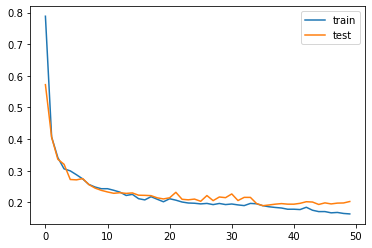

STAT NPER  10
STAT NPER  10
NIT  7
  Batches    City  D-Type  End  FB  Fi Nu  Lyr Neuro_How  Period  Phase  ...  \
0       -  DENVER     NaN  NaN NaN    NaN  NaN       NoB      10      1  ...   
0       -  DENVER     NaN  NaN NaN    NaN  NaN       NoB      10      1  ...   
0       -  DENVER     NaN  NaN NaN    NaN  NaN       NoB      10      1  ...   
0       -  DENVER     NaN  NaN NaN    NaN  NaN       NoB      10      1  ...   
0       -  DENVER     NaN  NaN NaN    NaN  NaN       NoB      10      0  ...   

   Te R2  Te Sp Te Su  Te Wi Tr Fa Tr R2 Tr Sp Tr Su  Tr Wi   Var  
0    NaN   1.20  1.22   0.97  0.96   NaN  0.96  0.92   0.77  TMIN  
0    NaN   1.09  1.28   0.88  0.88   NaN  0.92  0.87   0.77  TMIN  
0    NaN   1.11  1.20   0.97  0.89   NaN  0.83  0.84   0.77  TMIN  
0    NaN   1.32  1.28   0.91  0.98   NaN  0.80  0.81   0.81  TMIN  
0    NaN   1.27  1.20   0.82  1.00   NaN  0.86  1.01   0.77  TMIN  

[5 rows x 23 columns]
PPERIOD  10
ammsst.data.txt
amon.us.data.txt
epo.data

C:\Users\Science Joe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


LLEN  667 2 666 666 666
LLEN  160 2 160 160 160


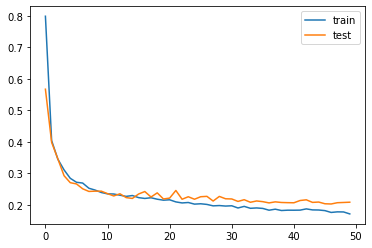

STAT NPER  10
STAT NPER  10
NIT  8
  Batches    City  D-Type  End  FB  Fi Nu  Lyr Neuro_How  Period  Phase  ...  \
0       -  DENVER     NaN  NaN NaN    NaN  NaN       NoB      10      1  ...   
0       -  DENVER     NaN  NaN NaN    NaN  NaN       NoB      10      1  ...   
0       -  DENVER     NaN  NaN NaN    NaN  NaN       NoB      10      1  ...   
0       -  DENVER     NaN  NaN NaN    NaN  NaN       NoB      10      1  ...   
0       -  DENVER     NaN  NaN NaN    NaN  NaN       NoB      10      0  ...   

   Te R2  Te Sp Te Su  Te Wi Tr Fa Tr R2 Tr Sp Tr Su  Tr Wi   Var  
0    NaN   1.20  1.22   0.97  0.96   NaN  0.96  0.92   0.77  TMIN  
0    NaN   1.09  1.28   0.88  0.88   NaN  0.92  0.87   0.77  TMIN  
0    NaN   1.11  1.20   0.97  0.89   NaN  0.83  0.84   0.77  TMIN  
0    NaN   1.32  1.28   0.91  0.98   NaN  0.80  0.81   0.81  TMIN  
0    NaN   1.27  1.20   0.82  1.00   NaN  0.86  1.01   0.77  TMIN  

[5 rows x 23 columns]
PPERIOD  10
ammsst.data.txt
amon.us.data.txt
epo.data

C:\Users\Science Joe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


LLEN  666 2 666 666 666
LLEN  160 2 160 160 160


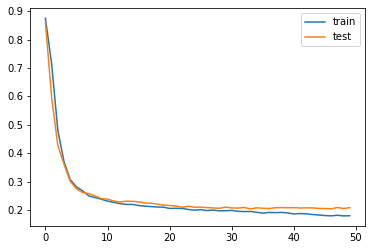

STAT NPER  10
STAT NPER  10
NIT  9
  Batches    City  D-Type  End  FB  Fi Nu  Lyr Neuro_How  Period  Phase  ...  \
0       -  DENVER     NaN  NaN NaN    NaN  NaN       NoB      10      1  ...   
0       -  DENVER     NaN  NaN NaN    NaN  NaN       NoB      10      1  ...   
0       -  DENVER     NaN  NaN NaN    NaN  NaN       NoB      10      1  ...   
0       -  DENVER     NaN  NaN NaN    NaN  NaN       NoB      10      1  ...   
0       -  DENVER     NaN  NaN NaN    NaN  NaN       NoB      10      0  ...   

   Te R2  Te Sp Te Su  Te Wi Tr Fa Tr R2 Tr Sp Tr Su  Tr Wi   Var  
0    NaN   1.20  1.22   0.97  0.96   NaN  0.96  0.92   0.77  TMIN  
0    NaN   1.09  1.28   0.88  0.88   NaN  0.92  0.87   0.77  TMIN  
0    NaN   1.11  1.20   0.97  0.89   NaN  0.83  0.84   0.77  TMIN  
0    NaN   1.32  1.28   0.91  0.98   NaN  0.80  0.81   0.81  TMIN  
0    NaN   1.27  1.20   0.82  1.00   NaN  0.86  1.01   0.77  TMIN  

[5 rows x 23 columns]
PPERIOD  10
ammsst.data.txt
amon.us.data.txt
epo.data

C:\Users\Science Joe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


LLEN  666 2 666 666 666
LLEN  159 2 158 158 158


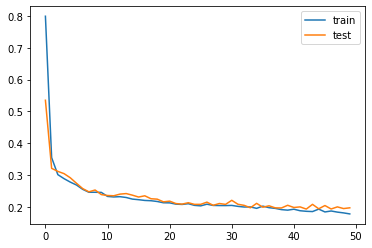

STAT NPER  10
STAT NPER  10
NIT  10
  Batches    City  D-Type  End  FB  Fi Nu  Lyr Neuro_How  Period  Phase  ...  \
0       -  DENVER     NaN  NaN NaN    NaN  NaN       NoB      10      1  ...   
0       -  DENVER     NaN  NaN NaN    NaN  NaN       NoB      10      1  ...   
0       -  DENVER     NaN  NaN NaN    NaN  NaN       NoB      10      1  ...   
0       -  DENVER     NaN  NaN NaN    NaN  NaN       NoB      10      1  ...   
0       -  DENVER     NaN  NaN NaN    NaN  NaN       NoB      10      0  ...   

   Te R2  Te Sp Te Su  Te Wi Tr Fa Tr R2 Tr Sp Tr Su  Tr Wi   Var  
0    NaN   1.20  1.22   0.97  0.96   NaN  0.96  0.92   0.77  TMIN  
0    NaN   1.09  1.28   0.88  0.88   NaN  0.92  0.87   0.77  TMIN  
0    NaN   1.11  1.20   0.97  0.89   NaN  0.83  0.84   0.77  TMIN  
0    NaN   1.32  1.28   0.91  0.98   NaN  0.80  0.81   0.81  TMIN  
0    NaN   1.27  1.20   0.82  1.00   NaN  0.86  1.01   0.77  TMIN  

[5 rows x 23 columns]
PPERIOD  10
ammsst.data.txt
amon.us.data.txt
epo.dat

C:\Users\Science Joe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


LLEN  665 2 664 664 664
LLEN  159 2 158 158 158


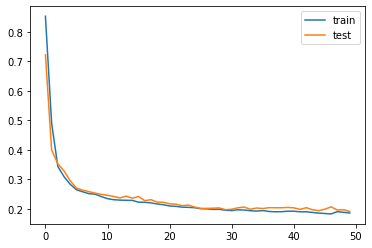

STAT NPER  10
STAT NPER  10
NIT  11
  Batches    City  D-Type  End  FB  Fi Nu  Lyr Neuro_How  Period  Phase  ...  \
0       -  DENVER     NaN  NaN NaN    NaN  NaN       NoB      10      1  ...   
0       -  DENVER     NaN  NaN NaN    NaN  NaN       NoB      10      1  ...   
0       -  DENVER     NaN  NaN NaN    NaN  NaN       NoB      10      1  ...   
0       -  DENVER     NaN  NaN NaN    NaN  NaN       NoB      10      1  ...   
0       -  DENVER     NaN  NaN NaN    NaN  NaN       NoB      10      0  ...   

   Te R2  Te Sp Te Su  Te Wi Tr Fa Tr R2 Tr Sp Tr Su  Tr Wi   Var  
0    NaN   1.20  1.22   0.97  0.96   NaN  0.96  0.92   0.77  TMIN  
0    NaN   1.09  1.28   0.88  0.88   NaN  0.92  0.87   0.77  TMIN  
0    NaN   1.11  1.20   0.97  0.89   NaN  0.83  0.84   0.77  TMIN  
0    NaN   1.32  1.28   0.91  0.98   NaN  0.80  0.81   0.81  TMIN  
0    NaN   1.27  1.20   0.82  1.00   NaN  0.86  1.01   0.77  TMIN  

[5 rows x 23 columns]


C:\Users\Science Joe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


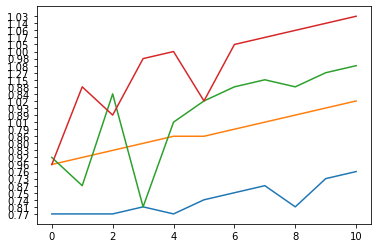

In [5]:
neuro_h=1
phase=1
period=10
nbatch=2
interactive=2
phases = [0,1,2,3,4,5,6]
for phase in phases:
    summry, new_list,nit = runApp(nbatch,neuro_h,phase,period,nit,summry,interactive)

x = [xx for xx in range(len(summry))]
plt.plot(x,summry["Tr Wi"])
plt.plot(x,summry["Tr Sp"])
plt.plot(x,summry["Tr Su"])
plt.plot(x,summry["Tr Fa"])